In [11]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
from collections import deque
from neurodynex.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
import math
from scipy.special import erf
from numpy.fft import rfft, irfft

# Include for the additive gaussian white noise function
from utility_functions import add_gaussian_white_noise_by_magnitude

b2.defaultclock.dt = 0.05 * b2.ms

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
N_excitatory=1024
N_inhibitory=256
N_extern_poisson=1000 
poisson_firing_rate=1.4 * b2.Hz
weight_scaling_factor=2.
sigma_weight_profile=20.
Jpos_excit2excit=1.6
stimulus_center_deg=180
stimulus_width_deg=40
stimulus_strength=0.07 * b2.namp
t_stimulus_start=0 * b2.ms
t_stimulus_duration=0 * b2.ms
distractor_center_deg=90
distractor_width_deg=40 
distractor_strength=0.0 * b2.namp
t_distractor_start=0 * b2.ms
t_distractor_duration=0 * b2.ms
G_inhib2inhib=.35 * 1.024 * b2.nS
G_inhib2excit=.35 * 1.336 * b2.nS
G_excit2excit=.35 * 0.381 * b2.nS
G_excit2inhib=.35 * 1.2 * 0.292 * b2.nS
monitored_subset_size=1024
sim_time=800. * b2.ms
synaptic_noise_amount=0.0
tau_excit     = None # Default is 20.0 * b2.ms (tau_excit needs to be higher than tau_inhib for bump maintenance)
tau_inhib     = None  # Default is 10.0 * b2.ms


In [5]:
# projectsions from the inhibitory populations
G_inhib2inhib *= weight_scaling_factor
G_inhib2excit *= weight_scaling_factor

# projections from the excitatory population
G_excit2excit *= weight_scaling_factor
G_excit2inhib *= weight_scaling_factor  # todo: verify this scaling


In [26]:
# precompute the weight profile for the recurrent population
tmp = math.sqrt(2. * math.pi) * sigma_weight_profile * erf(180. / math.sqrt(2.) / sigma_weight_profile) / 360.
Jneg_excit2excit = (1. - Jpos_excit2excit * tmp) / (1. - tmp)
presyn_weight_kernel = \
    [(Jneg_excit2excit +
      (Jpos_excit2excit - Jneg_excit2excit) *
      math.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / sigma_weight_profile ** 2))
     for j in range(N_excitatory)]

# Add noise to the synaptic weights
presyn_weight_kernel = add_gaussian_white_noise_by_magnitude(presyn_weight_kernel, synaptic_noise_amount)

# validate the normalization condition: (360./N_excitatory)*sum(presyn_weight_kernel)/360.
fft_presyn_weight_kernel = rfft(presyn_weight_kernel)
weight_profile_45 = deque(presyn_weight_kernel)   # deque: a bouble ended queue data structure
rot_dist = int(round(len(weight_profile_45) / 8)) # (len(weight_profile_45)==1024==N_excitatory)/8 = 128
weight_profile_45.rotate(rot_dist)                # rotate elements of the deque by 128 positions


In [31]:
min(presyn_weight_kernel), Jneg_excit2excit, max(presyn_weight_kernel), Jpos_excit2excit

(0.9029277169981036, 0.9029277169981036, 1.6, 1.6)

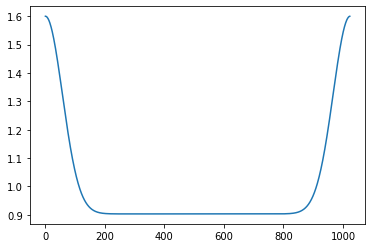

In [33]:
plt.plot(presyn_weight_kernel)

In [69]:
fft_presyn_weight_kernel

array([ 1.02400000e+03+0.00000000e+00j,  9.35268845e+01+3.33066907e-16j,
        7.79040918e+01-8.32667268e-17j,  5.74469008e+01+1.69309011e-15j,
        3.75020902e+01+4.16333634e-16j,  2.16733916e+01-8.32667268e-16j,
        1.10887046e+01+1.67227343e-15j,  5.02246927e+00-9.31546507e-16j,
        2.01389255e+00+6.93889390e-18j,  7.14887717e-01-1.38083989e-15j,
        2.24658011e-01+1.61112443e-15j,  6.25012235e-02-1.46172137e-15j,
        1.53935102e-02+9.15120844e-16j,  3.35636621e-03+1.44392690e-15j,
        6.47863558e-04+4.38534368e-16j,  1.10708329e-04-2.18160959e-15j,
        1.67478699e-05+1.05879118e-22j,  2.24295929e-06-1.38751105e-15j,
        2.65929029e-07-1.38167384e-15j,  2.79121072e-08+7.35707765e-16j,
        2.59359725e-09-6.57438221e-17j,  2.13349211e-10-5.40038907e-16j,
        1.55392358e-11+2.48846917e-16j,  1.00016744e-12-8.56889187e-16j,
        6.22814163e-14+4.65310589e-17j,  1.88030848e-15-1.55469220e-16j,
       -1.36444699e-15+4.85178260e-16j, -1.48416818

WARNING    /Users/john/Library/Python/3.7/lib/python/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]


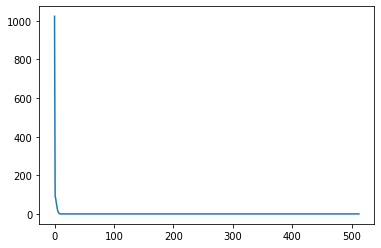

In [34]:
plt.plot(fft_presyn_weight_kernel)

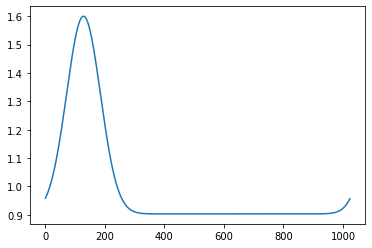

In [38]:
plt.plot(weight_profile_45)

In [40]:
rot_dist

128

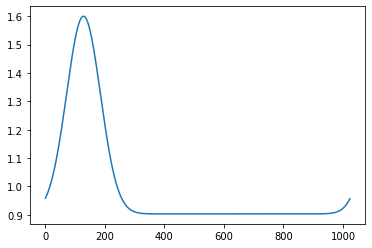

In [41]:
plt.plot(weight_profile_45)

In [42]:
len(weight_profile_45)

1024

In [43]:
1024/8

128.0

In [70]:
excit_pop = numpy.ones((1024,1024))
excit_pop

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [71]:
fft_s_NMDA = rfft(excit_pop)
fft_s_NMDA

array([[1024.+0.j,    0.+0.j,    0.-0.j, ...,    0.+0.j,    0.+0.j,
           0.+0.j],
       [1024.+0.j,    0.+0.j,    0.-0.j, ...,    0.+0.j,    0.+0.j,
           0.+0.j],
       [1024.+0.j,    0.+0.j,    0.-0.j, ...,    0.+0.j,    0.+0.j,
           0.+0.j],
       ...,
       [1024.+0.j,    0.+0.j,    0.-0.j, ...,    0.+0.j,    0.+0.j,
           0.+0.j],
       [1024.+0.j,    0.+0.j,    0.-0.j, ...,    0.+0.j,    0.+0.j,
           0.+0.j],
       [1024.+0.j,    0.+0.j,    0.-0.j, ...,    0.+0.j,    0.+0.j,
           0.+0.j]])

In [72]:
fft_s_NMDA_total = numpy.multiply(fft_presyn_weight_kernel, fft_s_NMDA)
fft_s_NMDA_total

array([[1048576.+0.j,       0.+0.j,       0.-0.j, ...,      -0.+0.j,
             -0.+0.j,       0.+0.j],
       [1048576.+0.j,       0.+0.j,       0.-0.j, ...,      -0.+0.j,
             -0.+0.j,       0.+0.j],
       [1048576.+0.j,       0.+0.j,       0.-0.j, ...,      -0.+0.j,
             -0.+0.j,       0.+0.j],
       ...,
       [1048576.+0.j,       0.+0.j,       0.-0.j, ...,      -0.+0.j,
             -0.+0.j,       0.+0.j],
       [1048576.+0.j,       0.+0.j,       0.-0.j, ...,      -0.+0.j,
             -0.+0.j,       0.+0.j],
       [1048576.+0.j,       0.+0.j,       0.-0.j, ...,      -0.+0.j,
             -0.+0.j,       0.+0.j]])

In [73]:
s_NMDA_tot = irfft(fft_s_NMDA_total)
s_NMDA_tot

array([[1024., 1024., 1024., ..., 1024., 1024., 1024.],
       [1024., 1024., 1024., ..., 1024., 1024., 1024.],
       [1024., 1024., 1024., ..., 1024., 1024., 1024.],
       ...,
       [1024., 1024., 1024., ..., 1024., 1024., 1024.],
       [1024., 1024., 1024., ..., 1024., 1024., 1024.],
       [1024., 1024., 1024., ..., 1024., 1024., 1024.]])

In [74]:
# precompute the weight profile for the recurrent population
tmp = math.sqrt(2. * math.pi) * sigma_weight_profile * erf(180. / math.sqrt(2.) / sigma_weight_profile) / 360.
Jneg_excit2excit = (1. - Jpos_excit2excit * tmp) / (1. - tmp)
presyn_weight_kernel = \
    [(Jneg_excit2excit + # Min
      (Jpos_excit2excit - Jneg_excit2excit) * # Range
      math.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / sigma_weight_profile ** 2))
     for j in range(N_excitatory)]


In [86]:
tmp, Jneg_excit2excit, Jpos_excit2excit, Jpos_excit2excit-Jneg_excit2excit

(0.13925712636838888, 0.9029277169981036, 1.6, 0.6970722830018965)

In [96]:
math.exp(-.5 * (360. * 0.1) ** 2 / sigma_weight_profile ** 2)

0.19789869908361465

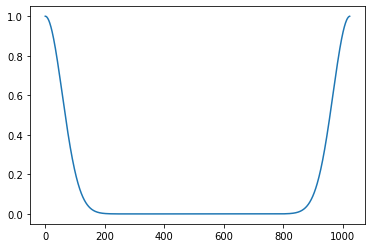

In [113]:
y1 = [math.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / sigma_weight_profile ** 2) for j in range(N_excitatory)]
plt.plot(y1)

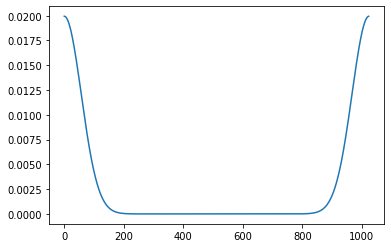

In [122]:
from scipy.stats import skewnorm
a = 0
y2 = [skewnorm.pdf(x=(360. * min(j, N_excitatory - j) / N_excitatory), a=a, scale=sigma_weight_profile) for j in range(N_excitatory)]
#plt.plot(y1)
plt.plot(y2)

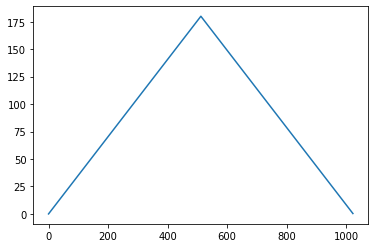

In [116]:
y3 = [(360. * min(j, N_excitatory - j) / N_excitatory) for j in range(N_excitatory)]
plt.plot(y3)

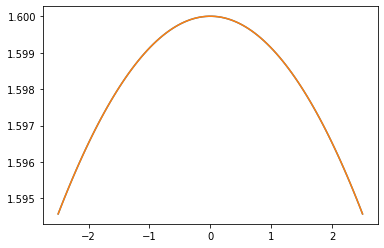

In [273]:
from scipy.stats import skewnorm
a = 0
scale = 20

x = numpy.linspace(-2.5, 2.5, 100)

y01 = Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * numpy.exp(-.5 * x ** 2 / scale ** 2)
y02 = skewnorm.pdf(x, a, loc=0, scale=scale)
y02 = Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * y02/numpy.max(y02)
plt.plot(x, y01)
plt.plot(x, y02)

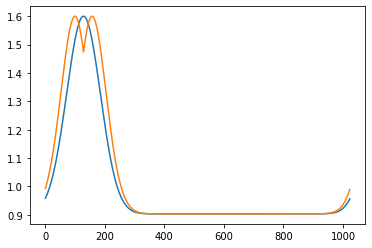

In [239]:
from scipy.stats import skewnorm
a = 1
scale = 20

x = numpy.linspace(-2.5, 2.5, 100)

y01 = numpy.array([Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * numpy.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / scale ** 2) for j in range(N_excitatory)])
y02 = numpy.array([skewnorm.pdf((360. * min(j, N_excitatory - j) / N_excitatory), a, loc=0, scale=scale) for j in range(N_excitatory)])
y02 = Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * y02/numpy.max(y02)
#plt.plot(x,y01)
#plt.plot(x, y02)

fft_presyn_weight_kernel_01 = rfft(y01)
weight_profile_45_01 = deque(y01)   # deque: a bouble ended queue data structure
rot_dist_01 = int(round(len(weight_profile_45_01) / 8)) # (len(weight_profile_45)==1024==N_excitatory)/8 = 128
weight_profile_45_01.rotate(rot_dist_01)                # rotate elements of the deque by 128 positions

fft_presyn_weight_kernel_02 = rfft(y02)
weight_profile_45_02 = deque(y02)   # deque: a bouble ended queue data structure
rot_dist_02 = int(round(len(weight_profile_45_02) / 8)) # (len(weight_profile_45)==1024==N_excitatory)/8 = 128
weight_profile_45_02.rotate(rot_dist_02)                # rotate elements of the deque by 128 positions


numpy.array_equal(y01, y02)
plt.plot(weight_profile_45_01)
plt.plot(weight_profile_45_02)
#plt.plot(y01-y02)

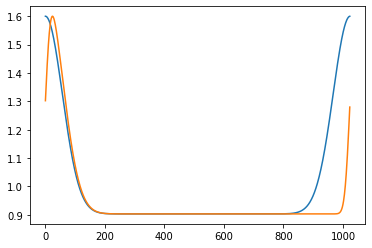

In [264]:
a = 4
scale = 20

x = numpy.linspace(-2.5, 2.5, 100)

y01 = numpy.array([Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * numpy.exp(-.5 * (360. * min(j, N_excitatory - j) / N_excitatory) ** 2 / scale ** 2) for j in range(N_excitatory)])
y01 = numpy.array([Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * numpy.exp(-.5 * (360. * (j - N_excitatory / 2) / N_excitatory) ** 2 / scale ** 2) for j in range(N_excitatory)])

fft_presyn_weight_kernel_01 = rfft(y01)
weight_profile_45_01 = deque(y01)   # deque: a bouble ended queue data structure
rot_dist_01 = int(round(len(weight_profile_45_01) / 2)) # (len(weight_profile_45)==1024==N_excitatory)/8 = 128
weight_profile_45_01.rotate(rot_dist_01)                # rotate elements of the deque by 128 positions

#plt.plot(y01)
plt.plot(weight_profile_45_01)

y02 = numpy.array([skewnorm.pdf((360. * min(j, N_excitatory - j) / N_excitatory), a, loc=0, scale=scale) for j in range(N_excitatory)])
y02 = numpy.array([skewnorm.pdf((360. * (j - N_excitatory / 2) / N_excitatory), a, loc=0, scale=scale) for j in range(N_excitatory)])
y02 = Jneg_excit2excit + (Jpos_excit2excit - Jneg_excit2excit) * y02/numpy.max(y02)

fft_presyn_weight_kernel_02 = rfft(y02)
weight_profile_45_02 = deque(y02)   # deque: a bouble ended queue data structure
rot_dist_02 = int(round(len(weight_profile_45_02) / 2)) # (len(weight_profile_45)==1024==N_excitatory)/8 = 128
weight_profile_45_02.rotate(rot_dist_02)                # rotate elements of the deque by 128 positions

#plt.plot(y02)
plt.plot(weight_profile_45_02)

In [267]:
list(weight_profile_45_02)

[1.3021684495328987,
 1.3244827820344625,
 1.3465428284088503,
 1.3682197679867143,
 1.3893888407623263,
 1.4099311930745766,
 1.4297355756064654,
 1.4486998528837356,
 1.466732290109117,
 1.4837525908965872,
 1.4996926679252618,
 1.5144971373463474,
 1.5281235365763228,
 1.5405422735373766,
 1.5517363231370518,
 1.5617006935354634,
 1.5704416903120835,
 1.5779760108635146,
 1.5843297041579776,
 1.5895370323304119,
 1.593639270578537,
 1.5966834805273122,
 1.5987212898267855,
 1.5998077074318449,
 1.6,
 1.5993566503629593,
 1.5979364143048425,
 1.5957974871265534,
 1.5929967868819688,
 1.5895893568980577,
 1.585627886365181,
 1.581162344497464,
 1.5762397210726165,
 1.5709038640886568,
 1.5651954038144265,
 1.5591517516287392,
 1.5528071616865757,
 1.5461928435522807,
 1.539337114422521,
 1.5322655803450518,
 1.5250013368428688,
 1.5175651805009918,
 1.5099758242960017,
 1.5022501106866817,
 1.4944032176880868,
 1.4864488542822922,
 1.478399442548568,
 1.4702662848053032,
 1.4620597148

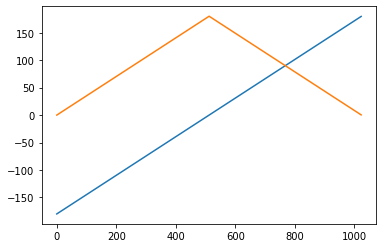

In [253]:
y03 = [(360. * (j - N_excitatory / 2) / N_excitatory) for j in range(N_excitatory)]
plt.plot(y03)
y04 = [(360. * min(j, N_excitatory - j) / N_excitatory) for j in range(N_excitatory)]
plt.plot(y04)

In [153]:
numpy.exp(-.5 * x ** 2 / sigma_weight_profile ** 2)

array([0.99221794, 0.99252802, 0.99283187, 0.99312948, 0.99342085,
       0.99370596, 0.99398482, 0.99425741, 0.99452374, 0.9947838 ,
       0.99503757, 0.99528507, 0.99552628, 0.9957612 , 0.99598982,
       0.99621214, 0.99642816, 0.99663786, 0.99684126, 0.99703834,
       0.9972291 , 0.99741353, 0.99759164, 0.99776342, 0.99792886,
       0.99808796, 0.99824073, 0.99838715, 0.99852722, 0.99866095,
       0.99878833, 0.99890935, 0.99902401, 0.99913232, 0.99923427,
       0.99932985, 0.99941907, 0.99950193, 0.99957842, 0.99964854,
       0.99971228, 0.99976966, 0.99982067, 0.9998653 , 0.99990355,
       0.99993544, 0.99996094, 0.99998007, 0.99999283, 0.9999992 ,
       0.9999992 , 0.99999283, 0.99998007, 0.99996094, 0.99993544,
       0.99990355, 0.9998653 , 0.99982067, 0.99976966, 0.99971228,
       0.99964854, 0.99957842, 0.99950193, 0.99941907, 0.99932985,
       0.99923427, 0.99913232, 0.99902401, 0.99890935, 0.99878833,
       0.99866095, 0.99852722, 0.99838715, 0.99824073, 0.99808

In [105]:
skewnorm.ppf(0.01, a)

-0.3030836671745017

In [106]:
skewnorm.ppf(0.99, a)

2.5758293035488857